In [242]:
import pandas as pd

# df=pd.read_csv("df_final_2.csv")
X_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
y_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
X_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
y_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

# X_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
# y_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
# X_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
# y_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

In [243]:
from sklearn.preprocessing import PolynomialFeatures

def get_aggregations(df, column_groupby, column_agg):

    if not isinstance(column_agg, list):
        column_agg = [column_agg]
    
    # Create the aggregation dictionary
    aggregation_dict = {}
    for col in column_agg:
        aggregation_dict.update({
            f'Median_{col}': (col, 'median'),
            f'Max_{col}': (col, 'max'),
            f'Min_{col}': (col, 'min'),
            f'Sum_{col}': (col, 'sum'),
            f'Std_{col}': (col, 'std'),
            f'Mean_{col}': (col, 'mean')
        })
    
    # Perform groupby and aggregation
    df_agg = df.groupby(column_groupby).agg(**aggregation_dict).reset_index()

    return df_agg

def get_polynomial_features(df, columns, degree=2):
    
    if not isinstance(columns, list):
        columns = [columns]
    # Initialize PolynomialFeatures with specified degree
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Select columns and generate polynomial features
    poly_features = df[columns]
    poly_array = poly.fit_transform(poly_features)
    
    # Get feature names and create DataFrame from polynomial array
    poly_feature_names = poly.get_feature_names_out(columns)
    poly_df = pd.DataFrame(poly_array, columns=poly_feature_names, index=df.index)
    
    # Concatenate the original DataFrame with polynomial features
    df_with_poly = pd.concat([df, poly_df], axis=1)

In [244]:
from sklearn.preprocessing import PolynomialFeatures

column_groupby = 'PCIAT-PCIAT_Total'
column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP','Physical-BMI','BIA-BIA_BMC']
# column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP','Physical-BMI' # 0.152

df_agg = get_aggregations(X_train, column_groupby=column_groupby, column_agg=column_agg)

for column in df_agg.columns:
    df_agg[column] = df_agg[column].fillna(df_agg[column].mean())

# # Verificar pra calcular separadamente ou tudo junto polinomios e relacoes se adicionar mais de uma coluna
# poly_df = get_polynomial_features(df_agg, columns=column_agg, degree=2)

# df_agg = pd.concat([df_agg, poly_df], axis=1)

In [245]:
print(f'Features with highest correlation to {column_groupby} \n')
columns_corr=[]
for column in column_agg:

    corr_df = df_agg.loc[:, df_agg.columns[df_agg.columns.str.endswith(column)].tolist()]
    corr_df[column_groupby] = df_agg[column_groupby]
    correlation_matrix = corr_df.corr()
    feature_highest_corr = correlation_matrix[column_groupby].drop(column_groupby).abs().idxmax()
    feature_corr_value = correlation_matrix[column_groupby].drop(column_groupby).abs().max()
    print(f'{feature_highest_corr}: {feature_corr_value} \n')

    columns_corr.append(feature_highest_corr)

print(columns_corr)

Features with highest correlation to PCIAT-PCIAT_Total 

Median_FGC-FGC_CU: 0.6644843180692392 

Min_Physical-Systolic_BP: 0.6429503351979634 

Min_Physical-Diastolic_BP: 0.6151229554265928 

Median_Physical-BMI: 0.65414920713236 

Median_BIA-BIA_BMC: 0.673042684902567 

['Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP', 'Median_Physical-BMI', 'Median_BIA-BIA_BMC']


In [246]:
columns = [column_groupby]
columns = columns + columns_corr
df_agg = df_agg.loc[:, columns]

In [247]:
df_agg.describe()

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP,Median_Physical-BMI,Median_BIA-BIA_BMC
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,46.075269,12.445055,94.763441,50.559140,19.788974,4.494338
std,27.112983,6.410102,16.542040,10.927093,4.013770,1.103305
min,0.000000,3.000000,49.000000,11.000000,15.515430,2.794585
25%,23.000000,8.000000,87.000000,45.000000,17.570840,3.651295
50%,46.000000,11.000000,93.000000,50.000000,18.618419,4.342710
75%,69.000000,14.000000,101.000000,56.000000,19.933707,4.914095
max,93.000000,35.000000,166.000000,87.000000,39.339185,8.182705


In [248]:
columns = [column_groupby]
columns = columns + columns_corr
print(columns)
new_X_train = X_train.merge(df_agg, how='left', on=column_groupby)[columns]

['PCIAT-PCIAT_Total', 'Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP', 'Median_Physical-BMI', 'Median_BIA-BIA_BMC']


In [249]:
for column in df_agg.columns:
    new_X_train[column] = new_X_train[column].fillna(df_agg[column].mean())

In [250]:
new_X_train.isna().sum()
len(new_X_train)

3960

In [251]:
new_df_train = new_X_train.select_dtypes(include='number')
correlation_matrix = new_df_train.corr()

In [252]:
correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP,Median_Physical-BMI,Median_BIA-BIA_BMC
PCIAT-PCIAT_Total,1.000000,0.798315,0.602366,0.533076,0.755443,0.760010
Median_FGC-FGC_CU,0.798315,1.000000,NaN,NaN,0.675867,0.747832
Min_Physical-Systolic_BP,0.602366,NaN,1.000000,0.619203,0.516170,NaN
Min_Physical-Diastolic_BP,0.533076,NaN,0.619203,1.000000,NaN,NaN
Median_Physical-BMI,0.755443,0.675867,0.516170,NaN,1.000000,0.670244
Median_BIA-BIA_BMC,0.760010,0.747832,NaN,NaN,0.670244,1.000000


In [253]:
from sklearn.model_selection import train_test_split

df = pd.concat([new_X_train, y_train], axis=1)
df = df[df['sii'].notna()]
X = df.iloc[:, :-1]
y = df['sii']
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)


In [254]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_split, y_train_split)
test_score = reg.score(X_test_split, y_test_split)
print(f'Test Score: {test_score}')

Test Score: 0.8435710393944422


In [255]:
null_indexes = y_train[y_train.isna()].index

In [256]:
X_null = new_X_train.iloc[null_indexes] 

In [257]:
y_pred = reg.predict(X_null) 

(array([   0.,    0.,    0.,    0.,    0., 1224.,    0.,    0.,    0.,
           0.]),
 array([0.7179831, 0.8179831, 0.9179831, 1.0179831, 1.1179831, 1.2179831,
        1.3179831, 1.4179831, 1.5179831, 1.6179831, 1.7179831]),
 <BarContainer object of 10 artists>)

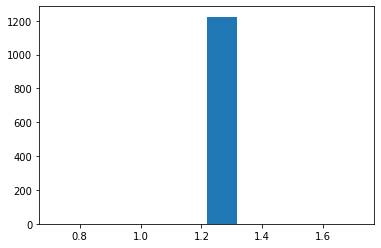

In [258]:
import matplotlib.pyplot as plt
plt.hist(y_pred)

In [259]:
y_train.iloc[null_indexes] = y_pred

In [260]:
y_train = np.round(y_train)

In [261]:
X_train = new_X_train.iloc[:, 1:]

In [262]:
reg_2 = LinearRegression()
reg_2.fit(X_train, y_train)

LinearRegression()

In [263]:
columns_agg_after = columns[1:]

In [264]:
print(column_agg)
print(columns_agg_after)

['FGC-FGC_CU', 'Physical-Systolic_BP', 'Physical-Diastolic_BP', 'Physical-BMI', 'BIA-BIA_BMC']
['Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP', 'Median_Physical-BMI', 'Median_BIA-BIA_BMC']


In [265]:
columns_agg_after[0]

'Median_FGC-FGC_CU'

In [266]:
X_test_predict = X_test.loc[:, column_agg]

In [267]:
for column in column_agg:
    index = column_agg.index(column)
    X_test_predict[columns_agg_after[index]] = X_test_predict[column].fillna(df_agg[columns_agg_after[index]].mean())

In [268]:
X_test_predict = X_test_predict.loc[:, columns_agg_after]
y_test = reg_2.predict(X_test_predict)

In [269]:
y_test

array([-0.2629507 , -0.29233387,  1.23129272,  1.25913102,  1.07077701,
        1.41645006,  1.27019609,  0.07797366,  1.07077701,  1.07077701,
        1.07077701,  1.07077701,  2.39603147,  0.41758851,  1.07077701,
        2.03156118,  0.1434855 ,  0.67047773,  1.88176699,  1.07077701])

In [270]:
conditions = [y_test <= 0, y_test <= 1, y_test <= 2, y_test <= 3]
choices = [0, 1, 2, 3]

In [271]:
y_test_round = np.select(conditions, choices, default=1)

In [272]:
df_y_test = pd.DataFrame({'id': X_test['id'], 'sii': y_test_round})

In [273]:
from datetime import datetime
df_y_test.to_csv(f'submission.csv', index=False)